<a href="https://colab.research.google.com/github/evakaldy/Bootcamp_Final_Project/blob/eva_database_exploration/00_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# # If you are importing notebooks, install the import-ipynb package:
!pip install import-ipynb


In [11]:
from google.colab import drive
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt

# Connect Google Disk

drive.mount('/content/drive')
# Navigate to the project folder
%cd  '/content/drive/MyDrive/Colab Notebooks/INTENSIVE_part_offline/final_project/'

%run give_df_from_sql.ipynb # to take the function from colab work...
from give_df_from_sql import give_df # importing my colab notebook

%run data_transform_final_project.ipynb
from data_transform_final_project import data_transform, statistical_difference, plot_variables_pvalue

%run data_transform_for_random_forrest.ipynb
from data_transform_for_random_forrest import tranform_df_for_random_forest

%run random_forest.ipynb
from random_forest import single_random_forest

%run randomly_selected_client_succes_rate.ipynb
from randomly_selected_client_succes_rate import succes_rate_random

%run lazy_predict_pr.ipynb
from lazy_predict_pr import run_lazy_predict

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/INTENSIVE_part_offline/final_project


In [12]:
## MERGE DATABASE & CONVERT to dataframe


# path to data on Google disk
db_path = '/content/drive/MyDrive/Colab Notebooks/INTENSIVE_part_offline/final_project/data.db'
merged_df = give_df(db_path)
merged_df.sample(5)

Accounts
sqlite_sequence
Campaigns
Clients
Outcomes


,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,pdays,previous,campaign,poutcome,y
3395,1941707,24,services,married,secondary,51.0,no,yes,yes,187,-1,0,2,unknown,unknown
10957,4045173,35,blue-collar,married,unknown,53.0,no,no,no,495,-1,0,2,unknown,unknown
18366,8580666,36,blue-collar,married,secondary,723.0,no,yes,no,101,-1,0,2,unknown,unknown
33874,2733974,29,management,married,tertiary,1441.0,no,yes,no,185,85,2,1,success,unknown
6393,2825172,37,blue-collar,single,tertiary,1222.0,no,no,no,212,-1,0,2,unknown,unknown


In [13]:
## TRANSFROM DATA into cathegorical, logaritmic, binary...
merged_df2 = data_transform(merged_df)

JOB CATEGORY converted to number): 
{'high_income': 0, 'low_income': 1, 'middle_income': 2}

--------------------------------
AGE converted to number: 
0 younger 30, 1 between 30 and 60' , 2 == older 60 

--------------------------------
PDAYS converted to number: 
0 smaller 50, 1 between 50 and 250' , 2 == greater 250 

--------------------------------
EDUCATION converted to number: 
2 'tertiary', 1 'secondary' , 0  'unknown' + 'primary' 

--------------------------------
EDUCATION converted to number: 
2 'tertiary', 1 'secondary' , 0  'unknown' + 'primary' 

--------------------------------
JOB CATEGORY converted to number): 
{'high_income': 0, 'low_income': 1, 'middle_income': 2}

--------------------------------
BALANCE made logaritmic (zero for balance <1): 

--------------------------------
DURATION made logaritmic (zero for balance <1): 

--------------------------------
CAMPAIHN converted to number: 
0 for pday<6, 1 for greater values 

--------------------------------
MARITAL 

In [14]:
# print(merged_df.head())

In [15]:
## REMOVE COLUMNS which are not numbers
only_nr_df = merged_df.drop(columns=['job', 'marital', 'job_category', 'education', 'housing', 'in_default', 'housing', 'loan', 'poutcome', 'y'], inplace=False)
# only_nr_df.head()

In [16]:
### DIVIDE into train_negative, train_positive and test
df_train_negative = only_nr_df[only_nr_df['y_nr'].isin([ 0])]
df_train_positive = only_nr_df[only_nr_df['y_nr'].isin([2])]
df_test = only_nr_df[only_nr_df['y_nr'].isin([1 ,3])]

# df_train_positive.head()

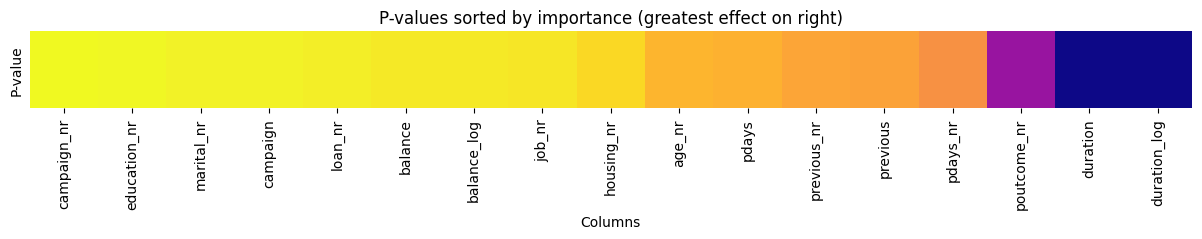

              Column        p-value  statistically_different
15     in_default_nr   1.000000e+00                        0
19  education_job_nr   9.096939e-01                        0
0                age   2.740020e-01                        0
14       campaign_nr   2.327907e-03                        1
10      education_nr   5.100841e-04                        1
8         marital_nr   1.719305e-05                        1
6           campaign   1.399791e-05                        1
17           loan_nr   2.914829e-06                        1
1            balance   1.096141e-07                        1
7        balance_log   8.140079e-08                        1
9             job_nr   1.036463e-08                        1
16        housing_nr   2.714700e-12                        1
11            age_nr   2.320748e-22                        1
4              pdays   5.717436e-24                        1
13       previous_nr   2.359972e-27                        1
5           previous   1

In [17]:
## CALCULATE THE STATICAL DIFFERENE between columns (for positive and negative)
p_value_df = statistical_difference(df_train_positive, df_train_negative)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

a = p_value_df.loc[p_value_df['statistically_different']==1]
# Create a heatmap-friendly DataFrame
p_value_df_sorted = np.log(a[['Column', 'p-value']].set_index('Column').sort_values(by='p-value', ascending=False))

# Plot the heatmap
plt.figure(figsize=(15, 1))  # Adjust the figure size as needed
sns.heatmap(p_value_df_sorted.T, cmap="plasma", cbar=False, fmt=".3e", xticklabels=True, yticklabels=False) # , annot=True

# Adding labels and title
plt.title('P-values sorted by importance (greatest effect on right)')
plt.xlabel('Columns')
plt.ylabel('P-value')
plt.xticks(rotation=90)
plt.show()

print(p_value_df.sort_values(by='p-value', ascending=False))

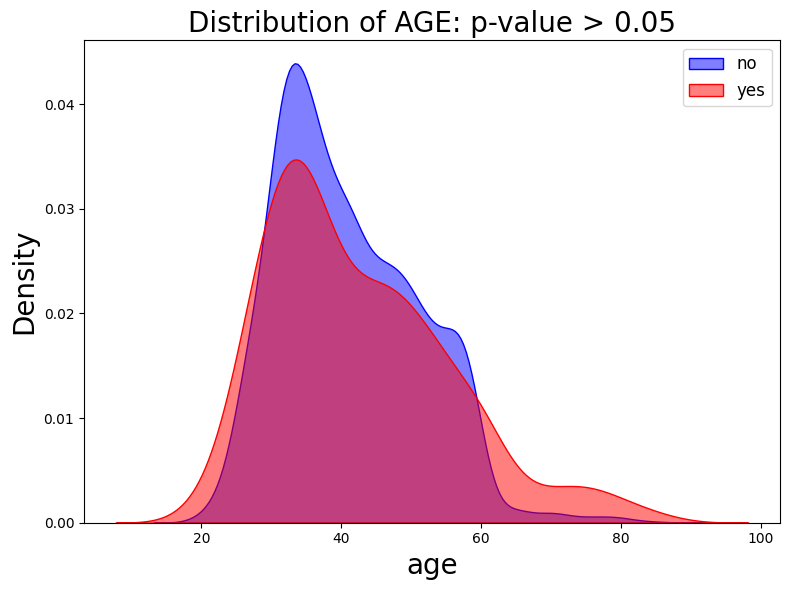

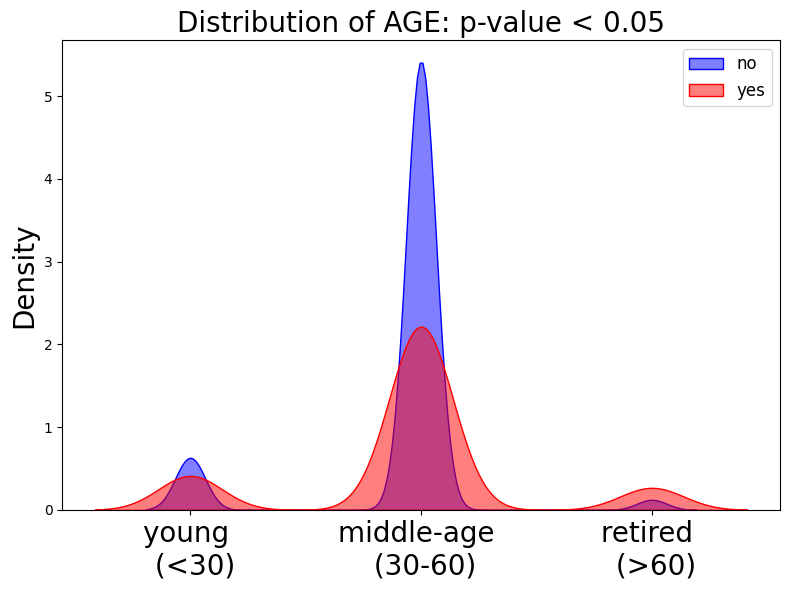

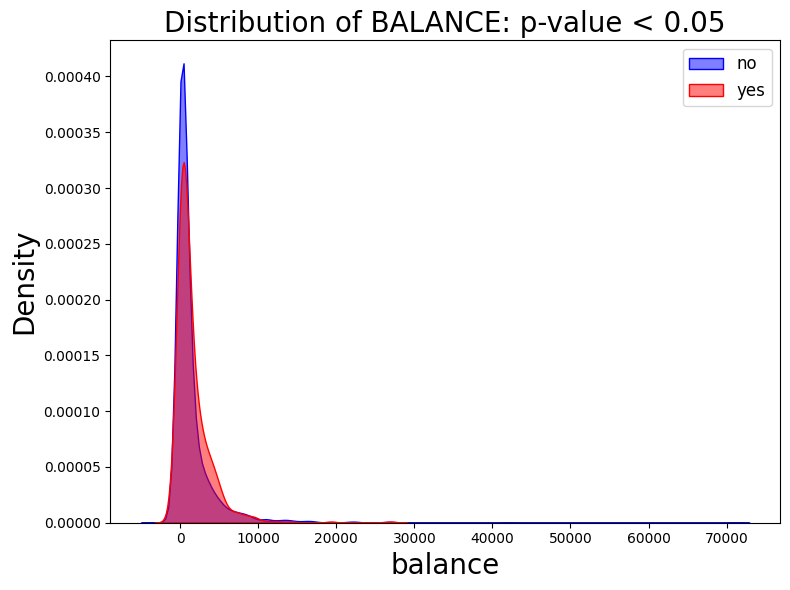

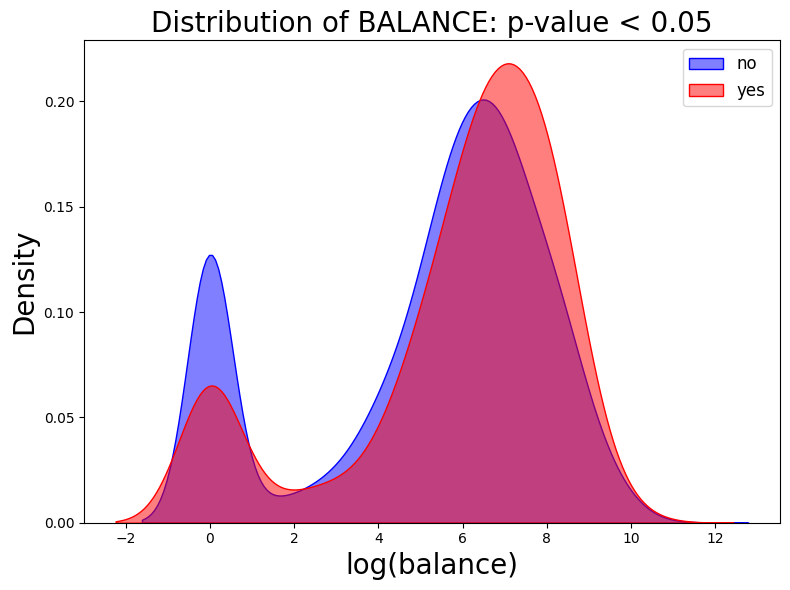

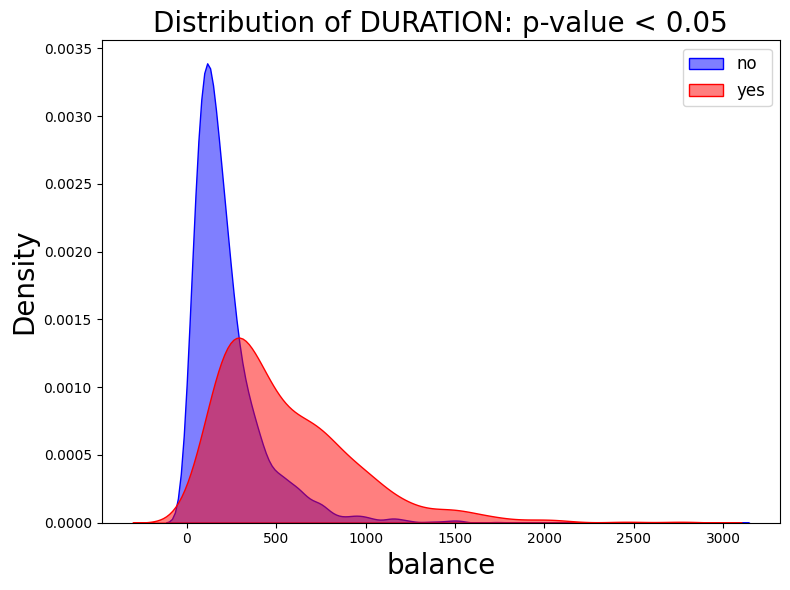

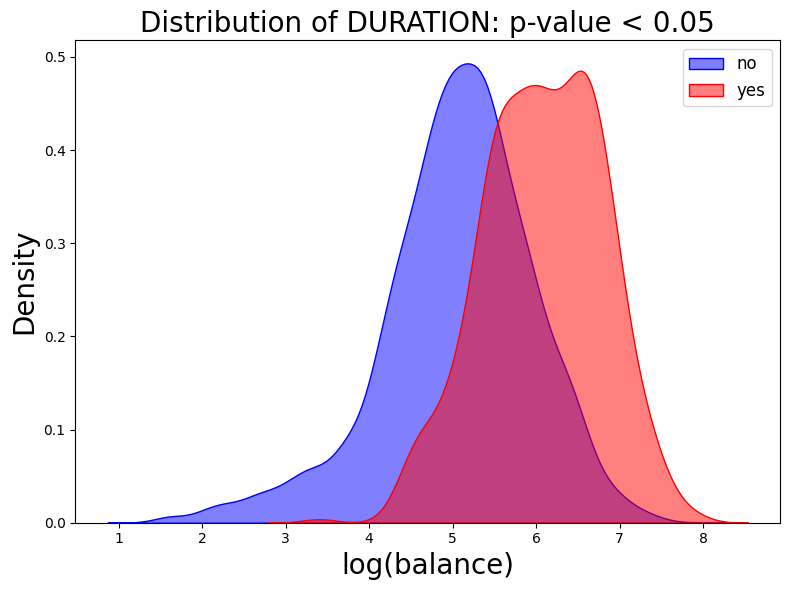

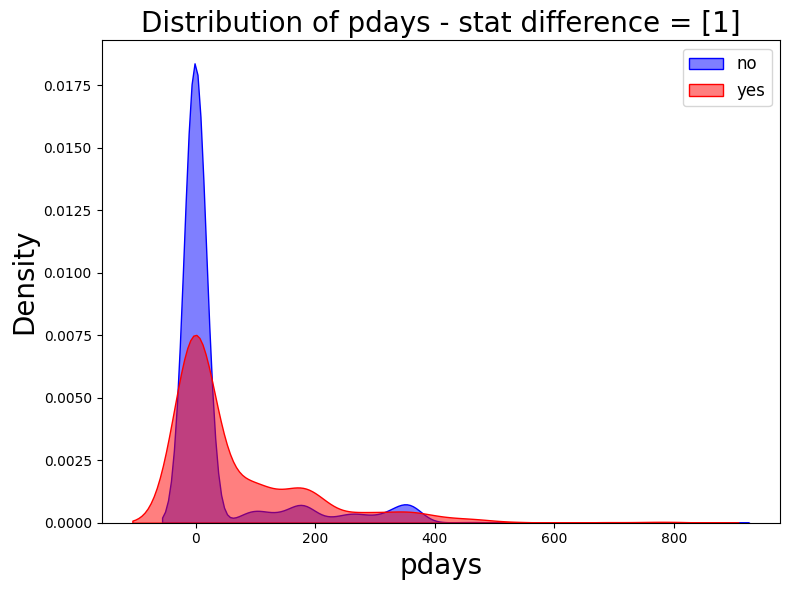

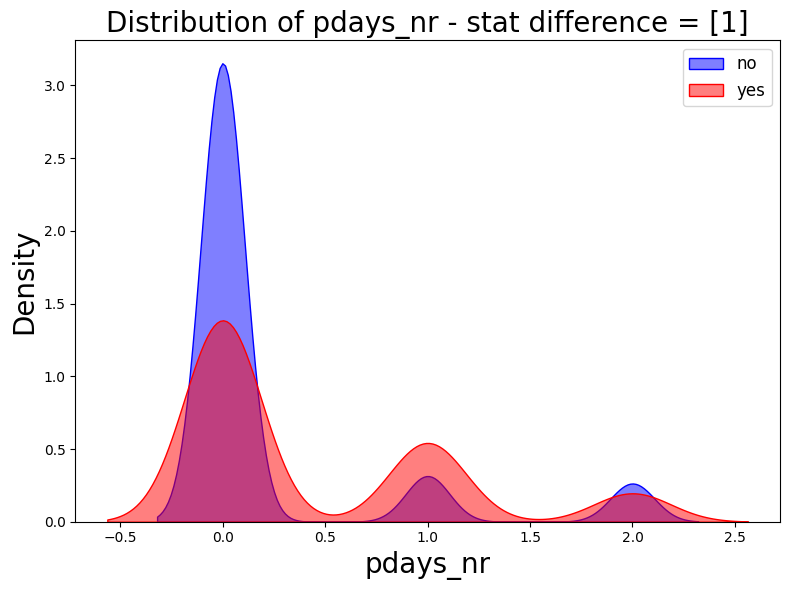

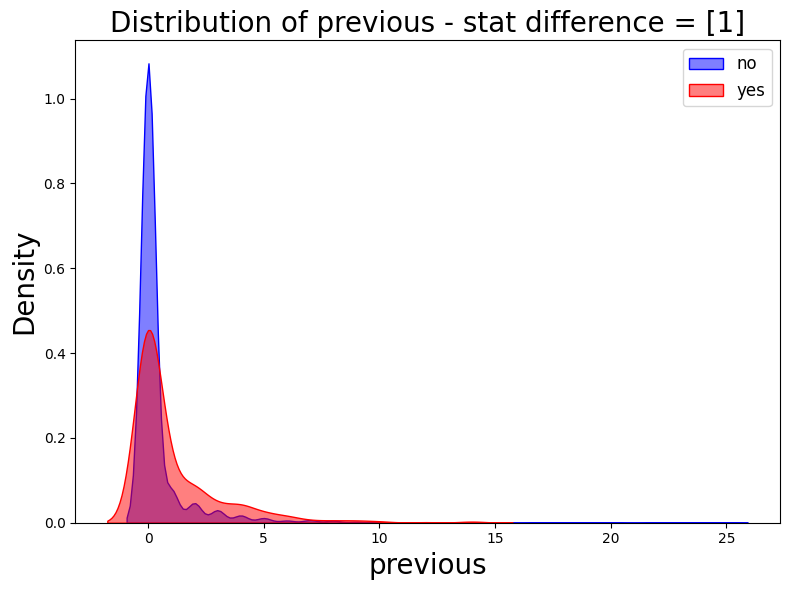

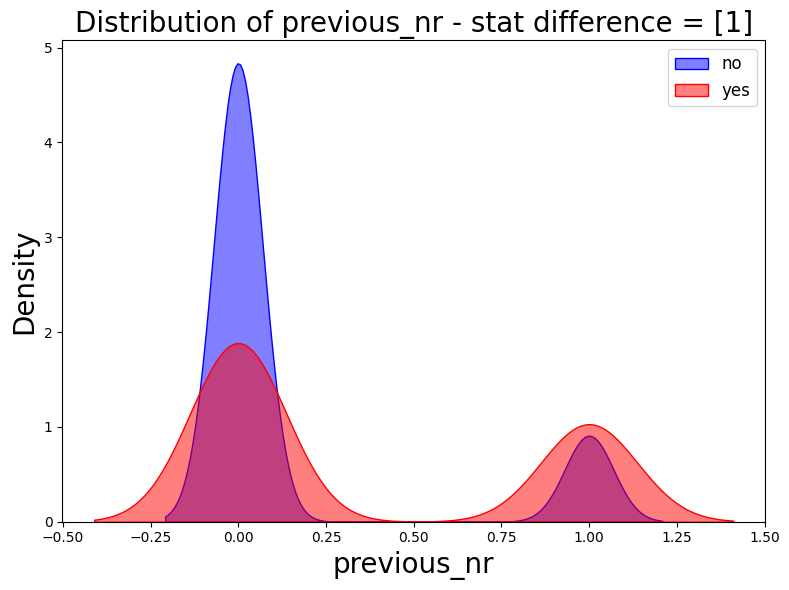

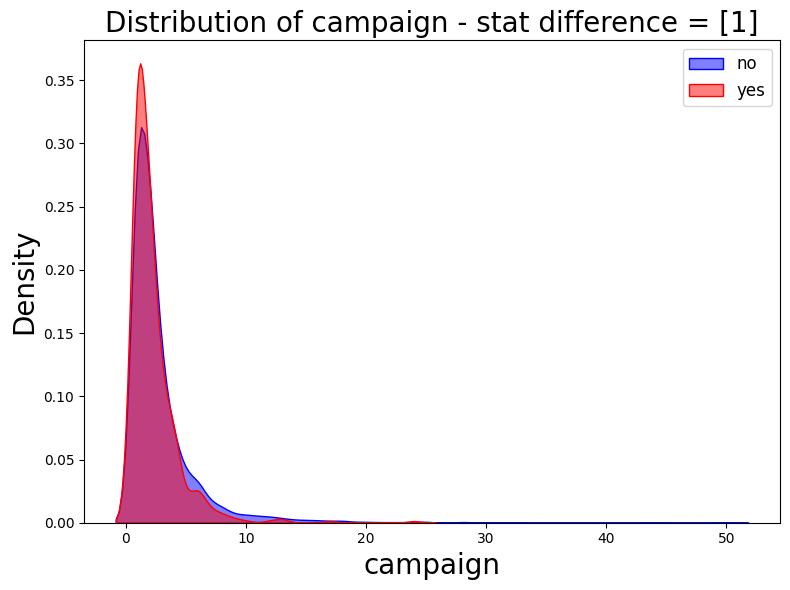

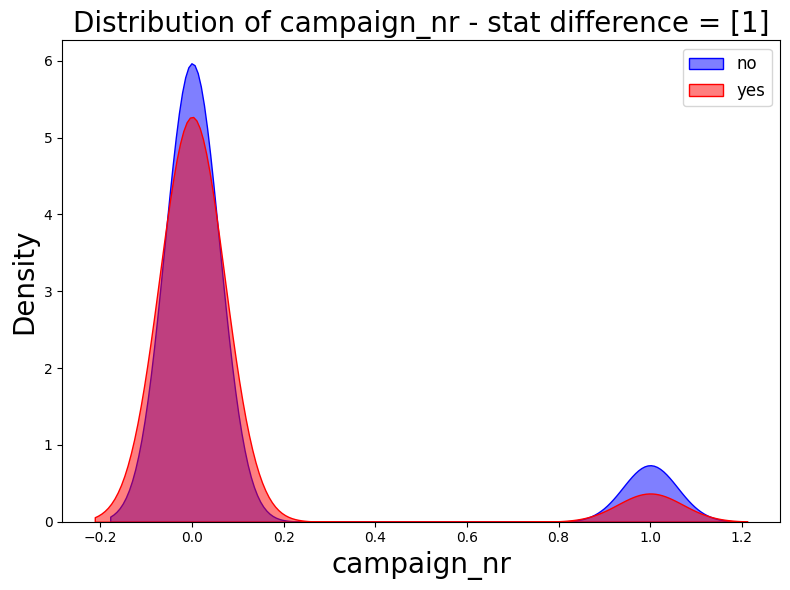

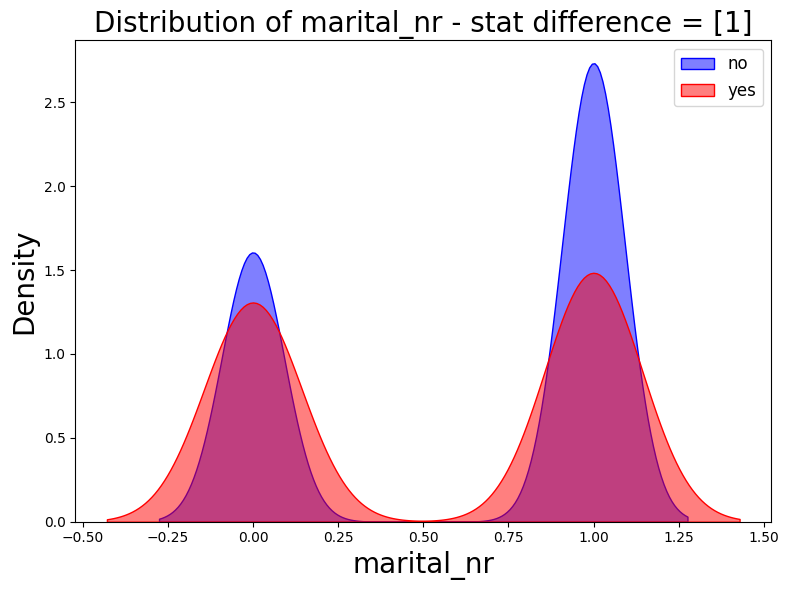

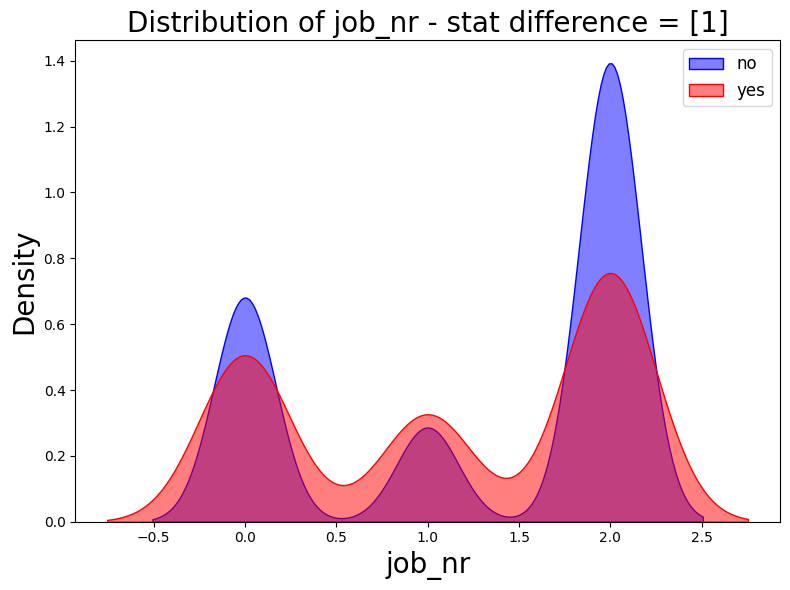

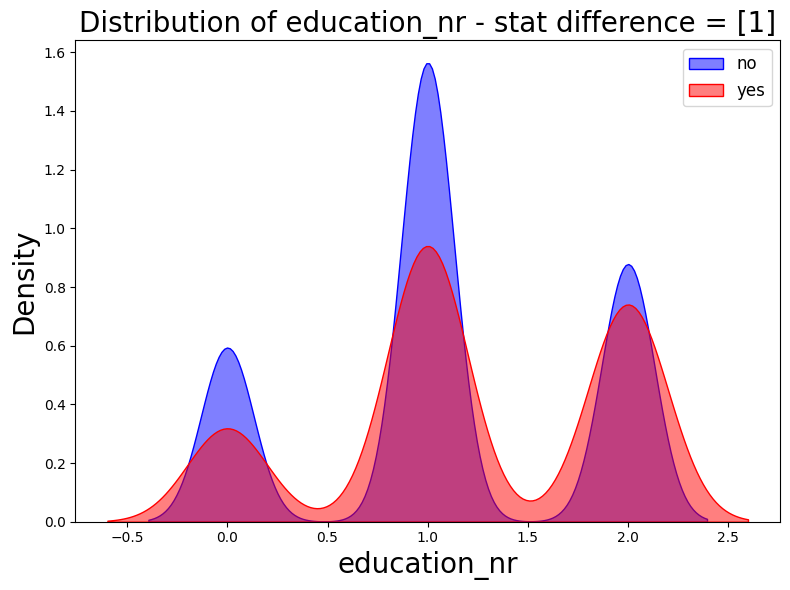

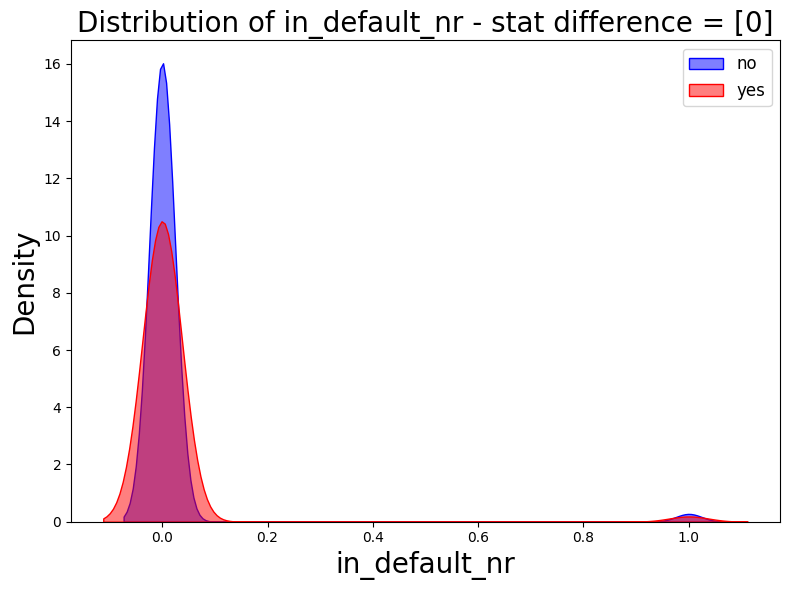

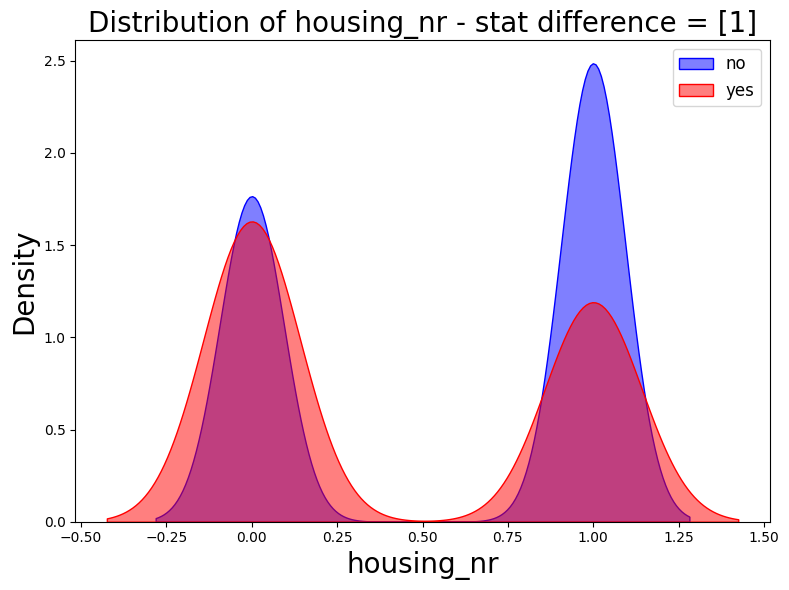

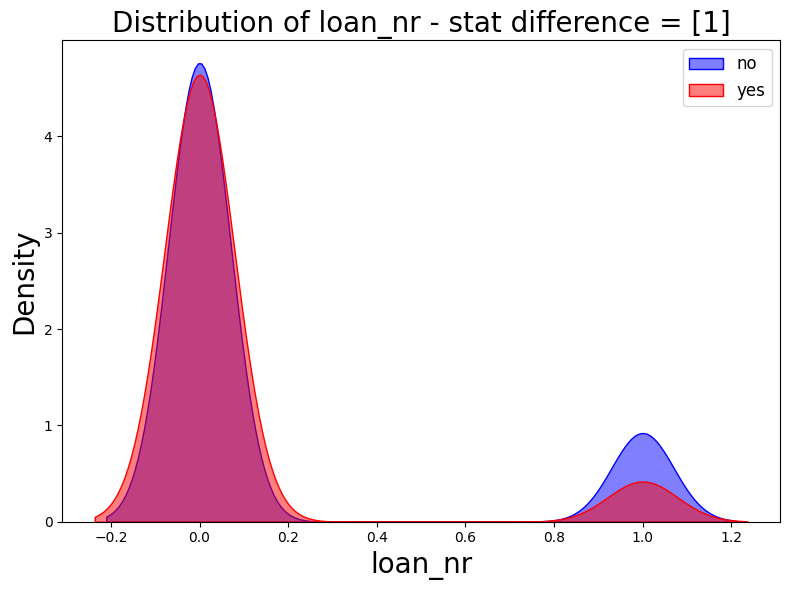

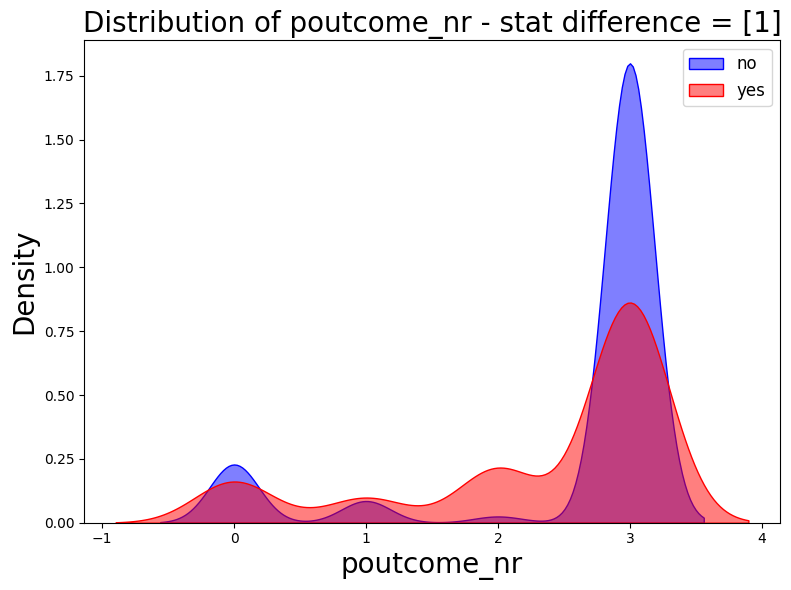

In [48]:
## PLOT the difference between positive and negative Y:
# each variable, before and after transformation
def plot_variables_pvalue(df_train_positive, df_train_negative, p_value_df):

  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Assuming the dataframes `df_train_negative` and `df_train_positive` exist
  columns_to_plot = ['age', 'age_nr', 'balance', 'balance_log', 'duration', 'duration_log','pdays', 'pdays_nr', 'previous', 'previous_nr',
                    'campaign', 'campaign_nr', 'marital_nr', 'job_nr', 'education_nr',
                    'in_default_nr', 'housing_nr', 'loan_nr', 'poutcome_nr']
  # columns_to_plot = columns_to_test_continuous + columns_to_test_cathegorical
  # Set up a valid Matplotlib style
  # plt.style.use('seaborn-darkgrid')  # This sets the Seaborn Darkgrid style correctly

  # Loop through each column and create the plots
  for column in columns_to_plot:
      plt.figure(figsize=(8, 6))  # Create a new figure for each column

      # Plot histogram or density plot for df_train_negative
      sns.kdeplot(df_train_negative[column], label='no', color='blue', fill=True, alpha=0.5)

      # Plot histogram or density plot for df_train_positive
      sns.kdeplot(df_train_positive[column], label='yes', color='red', fill=True, alpha=0.5)

      # Add title and labels
      plt.ylabel('Density', fontsize=20)
      plt.legend(fontsize=12)


      if column == 'age_nr':
        plt.xticks(ticks=[0, 1, 2], labels=['young \n (<30)', 'middle-age \n (30-60)', 'retired \n (>60)'], fontsize=20)
        plt.title(f"Distribution of AGE: p-value < 0.05", fontsize=20)
        plt.xlabel('', fontsize=20)
        plt.tight_layout()
        plt.savefig("age_bins.png", dpi=300)
      elif column == 'age':
        # plt.xticks(ticks=[0, 1, 2], labels=['young (<30)', 'middle-age (30-60)', 'retired (>60)'], fontsize=12)
        plt.title(f"Distribution of AGE: p-value > 0.05", fontsize=20)
        plt.xlabel('age', fontsize=20)
        plt.tight_layout()
        plt.savefig("age_cont.png", dpi=300)
      elif column == 'balance_log':

        plt.title(f"Distribution of BALANCE: p-value < 0.05", fontsize=20)
        plt.xlabel('log(balance)', fontsize=20)
        plt.tight_layout()
        plt.savefig("balance_log.png", dpi=300)
      elif column == 'balance':

        plt.title(f"Distribution of BALANCE: p-value < 0.05", fontsize=20)
        plt.xlabel('balance', fontsize=20)
        plt.tight_layout()
        plt.savefig("balance.png", dpi=300)
      elif column == 'duration':

        plt.title(f"Distribution of DURATION: p-value < 0.05", fontsize=20)
        plt.xlabel('balance', fontsize=20)
        plt.tight_layout()
        plt.savefig("duration.png", dpi=300)
      elif column == 'duration_log':

        plt.title(f"Distribution of DURATION: p-value < 0.05", fontsize=20)
        plt.xlabel('log(balance)', fontsize=20)
        plt.tight_layout()
        plt.savefig("duration_log.png", dpi=300)
      else:
        plt.xlabel(column, fontsize=20)
        plt.title(f"Distribution of {column} - stat difference = {p_value_df.loc[p_value_df['Column'] == column, 'statistically_different'].values}", fontsize=20)
        plt.tight_layout()



      # Show the plot

      plt.show()


plot_variables_pvalue(df_train_positive, df_train_negative, p_value_df)

In [19]:
## PREPARE DATA FOR RANDOM FOREST ANALYSIS
df_all_for_randomForest = tranform_df_for_random_forest(only_nr_df)

In [20]:
### DIVIDE into train_negative, train_positive and test
df_train_for_randomForest = df_all_for_randomForest[df_all_for_randomForest['y_nr'].isin([ 0, 2])]
df_forPrediction_for_randomForest = df_all_for_randomForest[df_all_for_randomForest['y_nr'].isin([1 ,3])]

df_train_for_randomForest.columns

Index(['client_id', 'marital_nr', 'housing_nr', 'loan_nr', 'y_nr', 'job_nr_0',
       'job_nr_1', 'job_nr_2', 'age_nr_0', 'age_nr_1', 'age_nr_2',
       'pdays_nr_0', 'pdays_nr_1', 'pdays_nr_2', 'education_nr_0',
       'education_nr_1', 'education_nr_2', 'campaign_nr_0', 'campaign_nr_1',
       'previous_nr_0', 'previous_nr_1', 'poutcome_nr_0', 'poutcome_nr_1',
       'poutcome_nr_2', 'poutcome_nr_3'],
      dtype='object')

In [21]:
## RANDOM FOREST - single on
rf_model = single_random_forest(df_train_for_randomForest)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1198
           2       0.54      0.18      0.27       159

    accuracy                           0.89      1357
   macro avg       0.72      0.58      0.60      1357
weighted avg       0.86      0.89      0.86      1357

Accuracy Score: 0.8857774502579219

-------------------------------------
Feature importance
marital_nr: 0.0992
housing_nr: 0.0984
loan_nr: 0.0552
job_nr_0: 0.0382
job_nr_1: 0.0344
job_nr_2: 0.0416
age_nr_0: 0.0328
age_nr_1: 0.0451
age_nr_2: 0.0610
pdays_nr_0: 0.0152
pdays_nr_1: 0.0388
pdays_nr_2: 0.0216
education_nr_0: 0.0369
education_nr_1: 0.0460
education_nr_2: 0.0455
campaign_nr_0: 0.0209
campaign_nr_1: 0.0196
previous_nr_0: 0.0149
previous_nr_1: 0.0121
poutcome_nr_0: 0.0434
poutcome_nr_1: 0.0309
poutcome_nr_2: 0.1364
poutcome_nr_3: 0.0119


In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import randint

# Define features and target
features = [
    'marital_nr', 'housing_nr', 'loan_nr', 'job_nr_0', 'job_nr_1', 'job_nr_2',
    'age_nr_0', 'age_nr_1', 'age_nr_2', 'pdays_nr_0', 'pdays_nr_1', 'pdays_nr_2',
    'education_nr_0', 'education_nr_1', 'education_nr_2', 'campaign_nr_0',
    'campaign_nr_1', 'previous_nr_0', 'previous_nr_1', 'poutcome_nr_0',
    'poutcome_nr_1', 'poutcome_nr_2', 'poutcome_nr_3'
]
target = 'y_nr'

X = df_train_for_randomForest[features]
y = df_train_for_randomForest[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': randint(10, 100),       # Number of trees
    'max_depth': randint(5, 30),           # Maximum depth of trees
    'min_samples_split': randint(2, 25),   # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 50)     # Minimum samples in a leaf node
    # 'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider for splits
    # 'bootstrap': [True, False]             # Use bootstrap sampling
}

# RandomizedSearchCV with cross-validation
rf_model_cv = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_model_cv, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=40, n_jobs=-1
)

# Fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters Found:")
print(random_search.best_params_)

# Predict on the test set
y_pred = best_rf_model.predict(X_test)
classification_report_test_group = classification_report(y_test, y_pred, output_dict=True)
# Evaluate the model
print("\nClassification Report from test group:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Feature Importance
print("\n-------------------------------------")
print("Feature Importance:")
importance = best_rf_model.feature_importances_
for i, feature in enumerate(features):
    print(f"{feature}: {importance[i]:.4f}")

Best Parameters Found:
{'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 49}

Classification Report from test group:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1198
           2       0.74      0.16      0.26       159

    accuracy                           0.89      1357
   macro avg       0.82      0.57      0.60      1357
weighted avg       0.88      0.89      0.86      1357


Accuracy Score: 0.894620486366986

-------------------------------------
Feature Importance:
marital_nr: 0.0328
housing_nr: 0.0642
loan_nr: 0.0260
job_nr_0: 0.0111
job_nr_1: 0.0255
job_nr_2: 0.0213
age_nr_0: 0.0216
age_nr_1: 0.0505
age_nr_2: 0.1135
pdays_nr_0: 0.0109
pdays_nr_1: 0.0877
pdays_nr_2: 0.0088
education_nr_0: 0.0129
education_nr_1: 0.0194
education_nr_2: 0.0234
campaign_nr_0: 0.0062
campaign_nr_1: 0.0078
previous_nr_0: 0.0379
previous_nr_1: 0.0318
poutcome_nr_0: 0.0667
poutcome_nr_1: 0.0166
poutcome_nr_2: 0.

In [23]:
classification_report_test_group

{'0': {'precision': 0.8987150415721844,
  'recall': 0.9924874791318865,
  'f1-score': 0.9432764775882586,
  'support': 1198.0},
 '2': {'precision': 0.7352941176470589,
  'recall': 0.15723270440251572,
  'f1-score': 0.25906735751295334,
  'support': 159.0},
 'accuracy': 0.894620486366986,
 'macro avg': {'precision': 0.8170045796096217,
  'recall': 0.5748600917672011,
  'f1-score': 0.601171917550606,
  'support': 1357.0},
 'weighted avg': {'precision': 0.8795669745831683,
  'recall': 0.894620486366986,
  'f1-score': 0.8631075386848146,
  'support': 1357.0}}

In [24]:
####PREDICT

# Predict on the test set
y_pred = best_rf_model.predict(df_forPrediction_for_randomForest[features])


print()
# Count occurrences of 2
count = np.count_nonzero(y_pred == 2)
print(f"Occurrences of 2 (nr of most likely clients): {count}")
print()

# merge predicted value of y to the dataframe with test:
df_test['y_predict']  = y_pred

# print(" length of vector predicted" , y_pred.shape)
# df_test.loc[df_test['y_predict'] == 2].nlargest(20, 'balance')


Occurrences of 2 (nr of most likely clients): 985



<ipython-input-24-22db3664e542>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_predict']  = y_pred


In [25]:
df_forPrediction_for_randomForest[features]

,marital_nr,housing_nr,loan_nr,job_nr_0,job_nr_1,job_nr_2,age_nr_0,age_nr_1,age_nr_2,pdays_nr_0,...,education_nr_1,education_nr_2,campaign_nr_0,campaign_nr_1,previous_nr_0,previous_nr_1,poutcome_nr_0,poutcome_nr_1,poutcome_nr_2,poutcome_nr_3
0,1,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,1,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45207,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45208,1,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45209,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [26]:
## SELECT the 1000 MOST BENEFICIAL clients that are likely to have y=yes
## Save the client IDs to a file named second_phase_target.csv.
## This file must contain exactly one column named "target".

# Filter rows where y_predict == 2
client_to_say_yes = df_test[df_test['y_predict'] == 2]
nr_client_to_say_yes = len(client_to_say_yes)
# Select the top 1000 rows with the highest balance
top_1000_client_to_say_yes = client_to_say_yes.nlargest(1000, 'balance')

# if the balance was kind of indicator of successfull campaign
sum_balance_selected_clients = top_1000_client_to_say_yes['balance'].sum()
# sum_balance_selected_clients * classification_report_test_group['2']['precision']
nr_expected_correct = round(classification_report_test_group['2']['precision'] * nr_client_to_say_yes )
mean_expected_revenue = np.mean(np.sum(np.random.choice(top_1000_client_to_say_yes['balance'],nr_expected_correct, replace=False)))
# print(f"sum_balance_selected_clients {sum_balance_selected_clients}, mean_expected_revenue {mean_expected_revenue}")
print()
print((f"If balance is the indicated of busines revenue"
       f" the most likely average revenue of these {nr_client_to_say_yes} selected client is {mean_expected_revenue} EUR"
       f" (assuming the precision {classification_report_test_group['2']['precision']})"
       f""))

# Keep only the "balance" column and rename it to "target"
output_df = top_1000_client_to_say_yes[['client_id']].rename(columns={'client_id': 'target'})

# Save to CSV
output_df.to_csv('second_phase_target_eva.csv', index=False)

print("------------------------------------")
print("HERE IS SAVED THE RESULT")
print("--------'second_phase_target.csv'----------")
# Print the result
print(output_df)


If balance is the indicated of busines revenue the most likely average revenue of these 985 selected client is 1434588.0 EUR (assuming the precision 0.7352941176470589)
------------------------------------
HERE IS SAVED THE RESULT
--------'second_phase_target.csv'----------
        target
43393  6494959
43053  6131459
44521  3879096
43019  4036514
43672  8528743
...        ...
43878  4948457
34160  4879287
41010  1687506
25282  4916642
30180  8880929

[985 rows x 1 columns]


In [27]:
!pip install lazypredict
run_lazy_predict(X, y)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
100%|██████████| 31/31 [00:03<00:00,  8.76it/s]


[LightGBM] [Info] Number of positive: 261, number of negative: 1999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 2260, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115487 -> initscore=-2.035882
[LightGBM] [Info] Start training from score -2.035882
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.77               0.62     0.62      0.80   
GaussianNB                         0.78               0.61     0.61      0.80   
PassiveAggressiveClassifier        0.81               0.60     0.60      0.82   
BernoulliNB                        0.79    

In [28]:
(df_train_positive, df_train_negative, df_test, client_to_say_yes, classification_report_test_group)

(       client_id  age  balance  duration  pdays  previous  campaign  job_nr  \
 86       4961336   56    45.00      1467     -1         0         1       2   
 1124     9306845   29   199.00      1689     -1         0         4       0   
 1416     5621406   43   388.00      2087     -1         0         2       0   
 1795     6432442   60    65.00      1028     -1         0         2       2   
 2096     5754389   32   311.00       757     -1         0         2       0   
 ...          ...  ...      ...       ...    ...       ...       ...     ...   
 45148    9539279   22  2488.00       449     38        10         2       1   
 45160    4645105   35     0.00       524     96         5         1       2   
 45191    9424440   75  3810.00       262    183         1         1       1   
 45197    2721327   36  1511.00       270     -1         0         1       0   
 45205    5547855   25   505.00       386     -1         0         2       2   
 
        age_nr  pdays_nr  ...  duratio

43       529.00
59       179.00
61       989.00
83      2343.00
87      1270.00
          ...  
45200    557.00
45201    583.00
45206    825.00
45208   5715.00
45210   2971.00
Name: balance, Length: 2697, dtype: float64
3 negative values were replaced with 0.
       client_id  balance  balance_positive
43       3746685   529.00            529.00
59       3834637   179.00            179.00
61       7443567   989.00            989.00
83       3421339  2343.00           2343.00
87       5869775  1270.00           1270.00
...          ...      ...               ...
45200    6519787   557.00            557.00
45201    9219966   583.00            583.00
45206    6145087   825.00            825.00
45208    9198356  5715.00           5715.00
45210    4225444  2971.00           2971.00

[2697 rows x 3 columns]
total_revenue 174.17467800000003


Text(0, 0.5, 'Frequency')

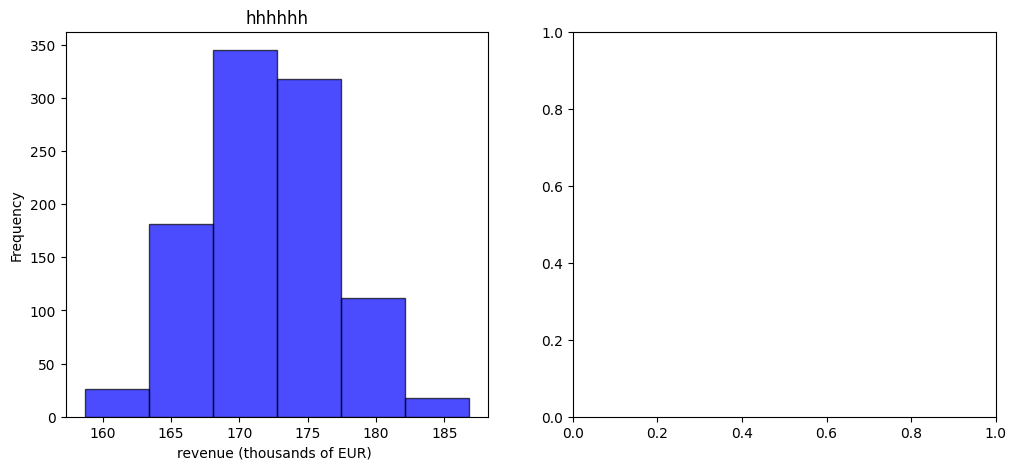

In [29]:
def total_return_thousandsEUR(num_reached, balances, alpha=0.05):
    return (-2 * num_reached + alpha * sum(balances) )/1000
# -2 * num_reached: This represents the cost of reaching out to num_reached individuals.
# calculates the total balance (or value) associated with the individuals reached.
#
def avg_return(num_reached, balances, alpha=0.05):
    return total_return_thousandsEUR(num_reached, balances, alpha) / num_reached



def random_balance_draw(balance_df, n_draw):
  # Randomly select `n` rows from the DataFrame
  # n_draw Specify the number of rows to sample
  random_sample = balance_df.sample(n=n_draw)  # Set a random state for reproducibility
  alpha=0.05

  total_revenue_rd = 0.001 * ( alpha * random_sample.sum() -2 * len(balance_df))
  # multiply by 0.001 to achive values in thousands of EUROS

  return total_revenue_rd



clients_to_contact = pd.read_csv("second_phase_target_evaluated.csv")
clients_to_contact.columns

# Filter the rows where 'client_id' matches 'target'
balances_to_contact = merged_df[
    merged_df['client_id'].isin(clients_to_contact['client_id'])
]['balance']

# Print or store the resulting column
print(balances_to_contact)

# If you want it as a DataFrame with 'client_id' and 'balance':
result_df = merged_df[
    merged_df['client_id'].isin(clients_to_contact['client_id'])
][['client_id', 'balance']]

result_df.columns

# Check for negative values in 'balance' column
negative_balances_count = (result_df['balance'] < 0).sum()
# Print how many values were replaced
print(f"{negative_balances_count} negative values were replaced with 0.")
# Check if 'balance' column has negative values and replace them with 0
result_df['balance_positive'] = result_df['balance'].apply(lambda x: max(x, 0))

# Verify the changes
print(result_df)

total_revenue = 0.62*total_return_thousandsEUR(num_reached=len(clients_to_contact), balances=result_df['balance_positive'], alpha=0.05)
print(f"total_revenue {total_revenue}")
# The first recommends 985 clients (expected success rate 74%),
# latter 2279 clients (expected success rate 57%). The overlap is 567 clients.
# Totalling in 2697 recommended clients.

(74*985 + 57*2279)/(985 + 2279)
# result_df
# total_revenue_rd = random_balance_draw(result_df['balance_positive'], 100)

revenue_suggested_clients = []
for i in range(1000):
  a  = random_balance_draw(result_df['balance_positive'], round(.62*len(clients_to_contact)))
  revenue_suggested_clients.append(a)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot histogram for y_nr_2_counts
axes[0].hist(revenue_suggested_clients, bins=6, color='blue', edgecolor='black', alpha=0.7, label='predicted clients')
axes[0].set_title(f"hhhhhh")
axes[0].set_xlabel("revenue (thousands of EUR) ")
axes[0].set_ylabel("Frequency")

nr_positive_y: 521, nr_negative_y: 4000, nr_unknown_y: 40690, nr_client_belived_to_say_yes: 2697

positive y in the train set: 11.5%, predicted positive y in the unknown set: 6.6000000000000005%
Correctly predicted class 2 (weighted for predictions of Ruku and Eva): 62.0%

If I randomly select 6.6000000000000005% (298 of 4521) of the training data,  what will be the success rate and revenue?

Assumption: distribution of y possitive and negative is the same in test group and in group where y is initially unknown 
percentage_success_mean 11.517449664429552


Text(0, 0.5, 'Occurence')

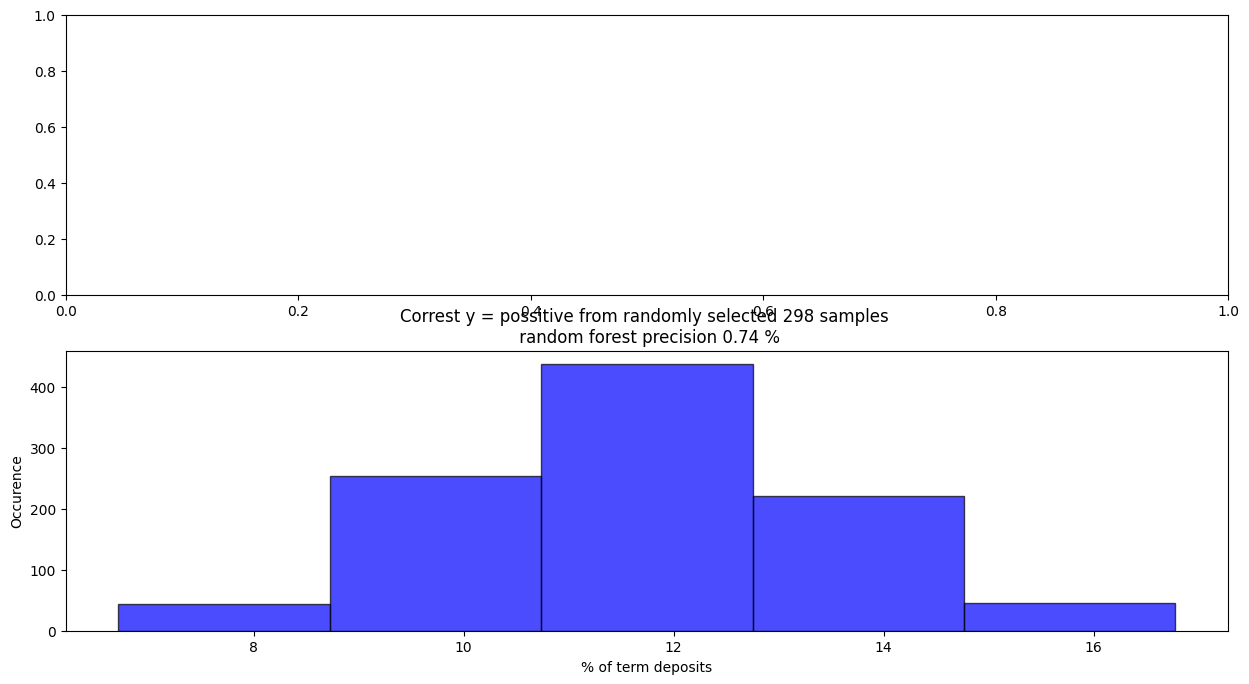

In [30]:
import pandas as pd

nr_positive_y = df_train_positive.shape[0]
nr_negative_y = df_train_negative.shape[0]
nr_unknown_y =  df_test.shape[0]
nr_client_belived_to_say_yes = 2697 # from Ruku and Eva

print(f"nr_positive_y: {nr_positive_y}, nr_negative_y: {nr_negative_y}, nr_unknown_y: {nr_unknown_y}, nr_client_belived_to_say_yes: {nr_client_belived_to_say_yes}")

percentage_positive_train = round(nr_positive_y/(nr_positive_y+nr_negative_y),3)
percentage_positive_test = 0.0660  #round(nr_client_belived_to_say_yes/nr_unknown_y ,3) # for some reason the formula does not round
precision_tested = 0.62 # weighted positive rate from Ruku and Eva
print()
print(f"positive y in the train set: {percentage_positive_train*100}%, "
  f"predicted positive y in the unknown set: {100 * percentage_positive_test}%")
print(f"Correctly predicted class 2 (weighted for predictions of Ruku and Eva): {precision_tested * 100}%")
print()

# train data set that has only info about the y and corresponding balance
# this set is meant for random drawing
train_y_balance = pd.concat([df_train_positive[['y_nr', 'balance']] , df_train_negative[['y_nr', 'balance']]])
# how many samples should be drawn to match the percentage drawn from unknown y?
n_draw = round(percentage_positive_test * (nr_positive_y + nr_negative_y))

print((f"If I randomly select {100 * percentage_positive_test}% ({n_draw} "
      f"of {(nr_positive_y + nr_negative_y)}) of the training data, "
      f" what will be the success rate and revenue?"))


print()
print('Assumption: distribution of y possitive and negative is the same in test group and in group where y is initially unknown ')



def random_sample_draw(train_y_balance, n_draw):
  # Randomly select `n` rows from the DataFrame
  # n_draw Specify the number of rows to sample
  random_sample = train_y_balance.sample(n=n_draw)  # Set a random state for reproducibility

  # Filter rows where 'y_nr' is equal to 2
  y_nr_2_rows = random_sample[random_sample['y_nr'] == 2]

  # Count occurrences where 'y_nr' equals 2
  y_nr_2_count = len(y_nr_2_rows)
  # the balance is for 298 draws from the train subset, we scale it as if 2697 draw were made
  # divida by 1000 to get better numbers
  y_nr_2_rows['balance_scaled'] = [x/298*2697 for x in y_nr_2_rows['balance']]
  # Sum the 'balance' column for these rows
  revenue_random = total_return_thousandsEUR(2697, y_nr_2_rows['balance_scaled'], alpha=0.05)
  # balance_sum_y_nr_2 = y_nr_2_rows['balance'].sum()
  # Output the results
  # print(f"Number of occurrences where y_nr == 2: {y_nr_2_count}")
  # print(f"Sum of 'balance' for rows where y_nr == 2: {revenue_random}")
  return y_nr_2_count, revenue_random

y_nr_2_count = []
revenue_random = []

for i in range(1000):
  a, b  = random_sample_draw(train_y_balance, n_draw)
  y_nr_2_count.append(a)
  revenue_random.append(b)


# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharey=False)
percentage_success = [x / n_draw * 100 for x in y_nr_2_count]
percentage_success_mean = sum(percentage_success)/len(percentage_success)
print(f"percentage_success_mean {percentage_success_mean}")
# Plot histogram for y_nr_2_counts
axes[1].hist(percentage_success, bins=5, color='blue', edgecolor='black', alpha=0.7, label='Random clients')
axes[1].set_title(f"Correst y = possitive from randomly selected {n_draw} samples \n random forest precision {round(classification_report_test_group['2']['precision'],2 )} %")
axes[1].set_xlabel("% of term deposits")
axes[1].set_ylabel("Occurence")


In [31]:
## ACTUAL REVENUE
# clients_to_contact = pd.read_csv("second_phase_target_evaluated.csv")
type(balances_to_contact)
print(f"balances_to_contact SUM {sum(balances_to_contact)}")
# Convert balances_to_contact Series to a DataFrame
balances_to_contact_df = balances_to_contact.to_frame(name='balance')

# If the Series has a meaningful index, keep it as 'client_id'
balances_to_contact_df.reset_index(inplace=True)
balances_to_contact_df.rename(columns={'index': 'client_id'}, inplace=True)

# Print the resulting DataFrame
print(balances_to_contact_df)

# Filter the balances where 'y' is 'yes'
filtered_balances_y_yes = balances_to_contact_df[clients_to_contact['y'] == 'yes']

revenue_actual = round(total_return_thousandsEUR(2697, filtered_balances_y_yes['balance'], alpha=0.05))
print(f"ACTUAL REVENUE is {(revenue_actual)} thousands EUR")
filtered_balances_y_yes['balance'].head()


balances_to_contact SUM 5725733.0
      client_id  balance
0            43   529.00
1            59   179.00
2            61   989.00
3            83  2343.00
4            87  1270.00
...         ...      ...
2692      45200   557.00
2693      45201   583.00
2694      45206   825.00
2695      45208  5715.00
2696      45210  2971.00

[2697 rows x 2 columns]
ACTUAL REVENUE is 173 thousands EUR


,balance
0,529.00
1,179.00
2,989.00
3,2343.00
4,1270.00


revenue_random_mean 19 thousands EUR
revenue_suggested_clients_mean 172 thousands EUR


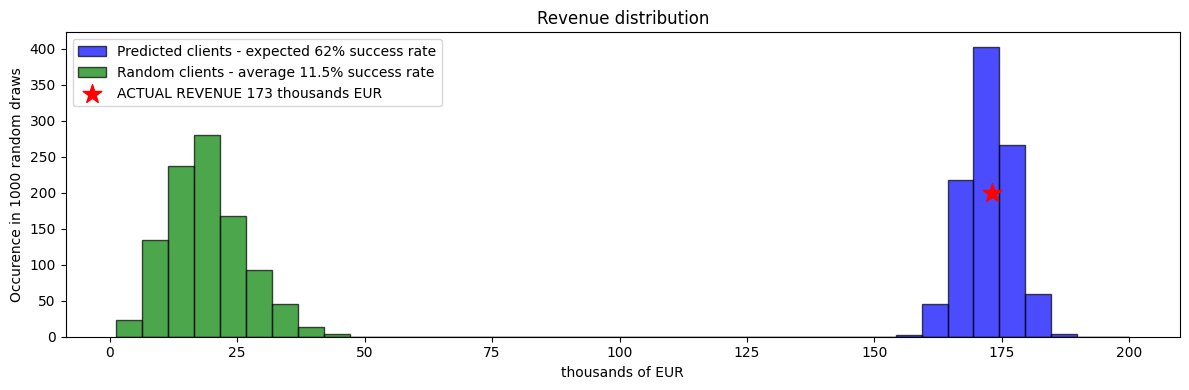

In [32]:
##PLOT , sumup

revenue_random_mean = round(sum(revenue_random)/len(revenue_random))
revenue_suggested_clients_mean = round(sum(revenue_suggested_clients)/len(revenue_suggested_clients))
print(f"revenue_random_mean {revenue_random_mean} thousands EUR")
print(f"revenue_suggested_clients_mean {revenue_suggested_clients_mean} thousands EUR")


plt.figure(figsize=(12, 4))
# Determine the range of both datasets
data_min = min(min(revenue_random), min(revenue_suggested_clients))
data_max = max(max(revenue_random), max(revenue_suggested_clients))

# Create bin edges based on the combined range
bins = np.linspace(data_min, 200, 40)  # 40 bins between min and max

plt.hist(revenue_suggested_clients, bins=bins, color='blue', edgecolor='black', alpha=0.7, label='Predicted clients - expected 62% success rate')
plt.hist(revenue_random, bins=bins, color='green', edgecolor='black', alpha=0.7, label='Random clients - average 11.5% success rate')
# Plot histogram for balance_sums_y_nr_2
plt.scatter(revenue_actual,200,
            label=f"ACTUAL REVENUE {revenue_actual} thousands EUR",
            marker='*',  # Star marker
            s=200,       # Size of the marker
            color='red') # Red color



plt.title("Revenue distribution")
plt.xlabel("thousands of EUR")
plt.ylabel("Occurence in 1000 random draws")

plt.legend()

# Show the plot
plt.tight_layout()
# Save the plot as a high-resolution PNG file
plt.savefig("revenue_distribution_prediction_plus_results2.png", dpi=300)  # 300 dpi for high resolution

# Show the plot
plt.show()

In [33]:
40619*0.125

5077.375